# Direct and Inverse Steady-State Thermal–Hydraulic Network Problems
## Reproducible Test Case and Reference Implementation

This Jupyter Notebook provides a reproducible reference implementation of the
test case presented in the publication:

**Mirco Ganz, Frank Tillenkamp, Christian Ghiaus**  
*Methodology for solving direct and inverse steady-state thermal–hydraulic network problems*

The notebook accompanies the paper and is intended to allow reviewers and
interested readers to reproduce all numerical results reported in the test case.


## Table of Contents

1. [Introduction](#introduction)
2. [Network Definition](#network-definition)
3. [Direct Problem Formulation](#direct-problem-formulation)
4. [Inverse Problem Formulation](#inverse-problem-formulation)
5. [Summary](#summary)


## 1. Introduction <a id="introduction"></a>

Steady-state thermal–hydraulic network models are widely used for the analysis,
design, and operation of energy systems such as refrigeration cycles, heat
pumps, and district heating networks. These systems are characterized by
strongly coupled mass, momentum, and energy transport phenomena, leading to
large nonlinear algebraic equation systems even under steady-state conditions.

In many practical applications, two distinct classes of problems arise.
In **direct problems**, system inputs such as boundary conditions, geometric
parameters, or control variables are prescribed, and the objective is to
compute the resulting steady-state operating point of the system. In contrast,
**inverse problems** aim to determine suitable input values such that prescribed
performance targets or operating constraints are satisfied. Typical examples
include set-point tracking, capacity control, and parameter identification.

Classical approaches commonly address inverse problems through repeated
solution of the corresponding direct problem, often embedded within an outer
optimization loop. While conceptually straightforward, such nested strategies
can become computationally expensive and numerically fragile for large-scale
networks with strong nonlinear couplings.

This notebook demonstrates a unified methodology for the formulation and
solution of both direct and inverse steady-state thermal–hydraulic problems
within a single modeling framework. The approach combines causal
(input–output) component models with acausal (implicit) balance equations at
the network level. System-level coupling is enforced through mass, energy, and
pressure continuity relations at junctions, while an established
tripartite-graph-based tearing strategy is used to reduce the dimensionality of
the resulting nonlinear system.

A key feature of the methodology is the formulation of inverse problems using a
**simultaneous analysis and design (SAND)** approach. Instead of repeatedly
solving the forward problem, selected system inputs and tearing variables are
treated as unknowns simultaneously. All steady-state balance equations and
constraints are enforced directly, while deviations from prescribed target
quantities are minimized within a single constrained optimization problem.

The methodology is illustrated using a single-stage vapor compression
refrigeration cycle. The notebook provides a transparent and reproducible
reference implementation of the framework accompanying the paper, allowing
readers and reviewers to explore the formulation, solution, and interpretation
of both direct and inverse problems in detail.


### 1.1 Purpose of this Notebook

The primary purpose of this notebook is to demonstrate how the proposed
methodology can be applied in practice using the provided Python framework.

Specifically, the notebook shows:

- how a steady-state thermo-hydraulic network is constructed from component models,
- how system-level coupling is enforced using junction balance equations,
- how a reduced nonlinear system is obtained using a graph-based tearing strategy,
- how both a **direct problem** and an **inverse problem** are formulated and solved
  within a unified modeling workflow.

All equations, modeling assumptions, and numerical settings correspond exactly
to those described in the paper. No additional modeling assumptions are introduced.


### 1.2 Scope and Reproducibility

This notebook focuses exclusively on steady-state operation.
Dynamic effects, transient behavior, and control dynamics are intentionally
excluded.

The notebook is designed such that:

- all results can be reproduced by executing the cells from top to bottom,
- all model parameters and solver settings are explicitly defined,
- the structure of the notebook mirrors the structure of the test case
  presented in Sections 4–5 of the paper.

The code cells appearing below correspond to the original implementation
used to generate the results in the publication.


### 1.3 Methodological Context

Steady-state thermal-hydraulic systems are governed by the conservation of mass,
momentum, and energy. While these physical laws define the system behavior,
they do not prescribe a computational evaluation order.

The proposed methodology combines:

- **causal component models**, evaluated using explicit input–output relations, and
- **acausal system-level coupling**, enforced through implicit junction balance equations.

This hybrid causal–acausal formulation enables flexible system assembly while
maintaining computational efficiency and physical consistency.


### 1.4 Direct and Inverse Problems

Two classes of computational problems are considered in this notebook.

A **direct problem** is defined as follows:
Given prescribed system inputs, determine all internal system states such that
all component models and junction balance equations are satisfied.

An **inverse problem** arises when desired system outputs are prescribed and
selected system inputs must be determined such that the specified outputs are
achieved while all physical constraints remain satisfied.

In the proposed framework, inverse problems are formulated as constrained
optimization problems and solved within the same modeling environment as
direct problems.


### 1.5 Implementation Overview

The following sections contain the Python implementation of the test case.

The overall structure follows this sequence:

1. Import of required libraries and framework modules  
2. Construction of the thermal-hydraulic network  
3. Definition of model parameters and boundary conditions  
4. Solution of the direct problem  
5. Solution of the inverse problem  

The code cells below correspond to the original implementation and are
augmented only with additional comments for clarity.


## 2. Network Definition <a id="network-definition"></a>

In this section, the thermal-hydraulic system is formulated as a network of
interconnected components and junctions.

The network representation provides a structured abstraction of the physical
system, in which components correspond to physical devices and junctions
represent points of mass, momentum, and energy coupling. This formulation
serves as the foundation for both the direct and inverse problem formulations
introduced later.

The following subsections describe the definition of fluid loops, the
construction of component objects, and the assembly of the network topology.

### 2.1 Framework Import

The following code cell imports the Python framework `th4din` used to construct and solve direct and inverse
steady-state thermal–hydraulic network problems.

The framework provides:

- component models for thermal-hydraulic devices,
- data structures for network and junction representation,
- automatic assembly of system-level balance equations,
- numerical solvers for direct and inverse problem formulations.

All subsequent code cells rely on this framework to define the test system and
to reproduce the results reported in the paper.


In [1]:
# import the framework
from th4din import *

### 2.2 Test Case Description

The considered test case is a vapor compression refrigeration system with
secondary fluid circuits on both the evaporator and condenser side.

The system consists of the following main components:

- a compressor,
- a condenser,
- a receiver,
- an internal heat exchanger (IHX),
- an expansion valve,
- an evaporator.

On the refrigerant side, the components form a closed loop operating with
R134a. On the secondary side, antifrogen circuits are connected to the
evaporator and condenser to represent the heat source and heat sink,
respectively.

A schematic representation of the system, including all components, ports,
and fluid loops, is shown in **Figure 1**.

Based on this physical configuration, the system is formulated as a
thermal-hydraulic network in the following.



![fig](fig/Model_Scheme.svg)

**Figure 1:** Schematic representation of the vapor compression refrigeration
system considered in this test case.

### 2.3 Network instantiation and Fluid Definition

The thermal-hydraulic network is represented as a network composed of interconnected
components and junctions.

At this stage, an empty network object is created. The network contains one or
more fluid loops, each representing a closed or open flow path of a working fluid
within the system.

Each fluid loop is associated with a specific working fluid. In the present test
case:

- fluid loop 1 corresponds to the refrigerant loop (R134a),
- fluid loops 2 and 3 correspond to the secondary fluid circuits
  (Antifrogen N at 40% concentration).

The fluid loop definitions by `net.fluid_loops[...]` are required to ensure consistent evaluation of
thermophysical properties throughout the network, which are computed using Coolprop library [1].



In [2]:
net = Network()

net.fluid_loops[1] = "R134a"
net.fluid_loops[2] = "INCOMP::AN[0.4]"
net.fluid_loops[3] = "INCOMP::AN[0.4]"


### 2.4 Component Models

The thermal–hydraulic network is constructed from component models representing
the physical devices of the refrigeration system.

Each component is classified according to its computational causality as either

- a **mass-flow-based component**, or  
- a **pressure-based component**,

as described in the paper.

Mass-flow-based components require pressure, specific enthalpy, and mass flow
rate at their inlet ports as inputs and compute the corresponding pressure,
specific enthalpy, and mass flow rate at the outlet ports.

Pressure-based components require pressure and specific enthalpy at their inlet
ports, as well as the pressure at the outlet ports. They compute the mass flow
rates at all inlet and outlet ports together with the outlet specific enthalpy.

The computational causality of the two component types is summarized in
**Table 1**, while **Figure 2** illustrates the schematic component representation
and the corresponding causal model formulation for a compressor and a heat
exchanger.

This distinction enables a hybrid causal–acausal formulation in which component
models are evaluated causally, while system-level coupling is enforced implicitly
through junction mass, momentum, and energy balance equations.

| Causality type | Inputs $\mathbf{u}$                          | Outputs $\mathbf{y}$                                     |
|---------------|----------------------------------------------|----------------------------------------------------------|
| Pressure-based component | $p, h$ at inlet ports<br>$p$ at outlet ports | $\dot{m}$ at inlet ports<br>$h, \dot{m}$ at outlet ports |
| Mass-flow-based component | $p, h, \dot{m}$ at inlet ports               | $p, h, \dot{m}$ at outlet ports                          |

*Table 1: Computational causality of component models.*


![fig](fig/Component_Causality_Representation.svg)


**Figure 2:** Schematic component- and corresponding causal model representation of a compressor and heat exchanger model

#### 2.4.1 Component Instantiation and Port Causality Definition

Based on the component causality classification introduced above, the individual
component models of the vapor compression refrigeration cycle from **Figure 1** are instantiated in the following
code cell.

Each component is created as either a `MassFlowBased` or a `PressureBased`
component. The ports of each component are explicitly defined using the
`port_specs` dictionary. This dictionary assigns a computational role to each
port by specifying whether it is treated as an inlet or an outlet with respect
to the mass, energy, and momentum balance equations.

This explicit port-level causality definition enables the framework to
automatically assemble the corresponding balance equations and to determine the
direction of information flow within each component, while preserving acausal
coupling at the network level through junction equations.


In [3]:
# Defining component models of the network

# The dictionary `port_specs` defines the ports of a component and their computational role.

# Each entry maps a user-defined port name to a PortSpec object, which
# specifies whether the port is treated as an inlet ("in") or an outlet ("out")
# with respect to mass, energy, and momentum balance equations.


# Evaporator
evap = MassFlowBasedComponent(
    label="Evap",
    port_specs={
        "in_af":  PortSpec("in"),
        "out_af": PortSpec("out"),
        "in_r": PortSpec("in"),
        "out_r":PortSpec("out"),
    },
)

# Compressor
comp = PressureBasedComponent(
    label="Comp",
    port_specs={
        "in":  PortSpec("in"),
        "out": PortSpec("out"),
    },
)

# Condenser
cond = MassFlowBasedComponent(
    label="Cond",
    port_specs={
        "in_r":  PortSpec("in"),
        "out_r": PortSpec("out"),
        "in_af": PortSpec("in"),
        "out_af":PortSpec("out"),
    },
)

# Expansion Valve
exp = PressureBasedComponent(
    label="Exp",
    port_specs={
        "in":  PortSpec("in"),
        "out": PortSpec("out"),
    },
)

# Receiver
rev = MassFlowBasedComponent(
    label="Rev",
    port_specs={
        "in":  PortSpec("in"),
        "out": PortSpec("out"),
    },
)

# Internal Heat Exchanger
ihx = MassFlowBasedComponent(
    label="IHX",
    port_specs={
        "in_hot":  PortSpec("in"),
        "out_hot": PortSpec("out"),
        "in_cold": PortSpec("in"),
        "out_cold":PortSpec("out"),
    },
)


#### 2.4.2 Adding Components to the Network

After defining the individual component instances and their port-level
computational causality, the components are added to the network using the
`net.add_component(...)` method.

Adding a component to the network registers it as a component in the internal network
graph representation. At this stage, each component exists independently and is
not yet coupled to other components. No balance equations are assembled and no
inter-component relations are enforced until explicit connections between ports
are defined in a subsequent step.

This clear separation between component definition and network assembly enables
a modular and transparent modeling workflow, in which components can be reused,
reconfigured, or replaced without modifying the underlying network structure.

In [4]:
# adds components to the network
net.add_component(comp)
net.add_component(cond)
net.add_component(evap)
net.add_component(exp)
net.add_component(ihx)
net.add_component(rev)

#### 2.4.3 Model Parameters and Outputs

In addition to the network topology and component models, the framework requires
the explicit declaration of model parameters and system outputs.

**Model parameters**, registered using the method `net.add_parameter(...)`,
represent quantities that are required by the component models during their
evaluation but are not part of the system state vector. Typical examples include
geometric properties, control inputs, and empirical coefficients. Model
parameters are treated as fixed values in direct problems and may optionally be
declared as optimization variables in inverse problems using
`net.set_parameter(...)`.

**System outputs**, registered via the method `net.add_output(...)`, represent
quantities of interest that are computed once the network equations have been
solved. Outputs do not participate in the enforcement of physical consistency,
but are extracted for post-processing, visualization, and for the formulation
of objective functions in inverse problems.

In the following code cell, all model parameters and system outputs required for
the present test case are registered at the network level using
`net.add_parameter(...)` and `net.add_output(...)`.


#### 2.4.4 Overview of Model Parameters and Outputs

For clarity, the model parameters and system outputs used in the present test
case are briefly summarized below before they are registered using
`net.add_parameter(...)` and `net.add_output(...)`.

**Model parameters** (registered via `net.add_parameter(...)`) include:

- **Compressor**
  - `omega`: compressor rotational speed [1/s]

- **Condenser**
  - `A`: heat exchanger surface area [m$^2$]
  - `U`: overall heat transfer coefficient [W/m$^2$K]

- **Evaporator**
  - `A`: heat exchanger surface area [m$^2$]
  - `U`: overall heat transfer coefficient [W/m$^2$K]

- **Internal heat exchanger (IHX)**
  - `A`: heat exchanger surface area [m$^2$]
  - `U`: overall heat transfer coefficient [W/m$^2$K]

- **Expansion valve**
  - `Cf`: valve flow coefficient [m$^2$]
  - `Av`: normalized valve opening area [-]

**System outputs** (registered via `net.add_output(...)`) include:

- `Q` (Evaporator): evaporator heat transfer rate [W]
- `Q` (Condenser): condenser heat transfer rate [W]
- `P` (Compressor): compressor power consumption [W]
- `dTsh` (Evaporator): evaporator outlet superheat [K]

In [5]:
# The function `net.add_parameter` registers component-specific model parameters
# at the network level.
#
# Model parameters are quantities required by the component models during
# evaluation but are not part of the system state vector.
#
# Each parameter is uniquely identified by the component label and the parameter
# name as used inside the corresponding component model.

net.add_parameter("Comp", "omega")   # compressor rotational speed [1/s]

net.add_parameter("Cond", "A")     # condenser heat exchanger surface area [m²]
net.add_parameter("Cond", "U")     # condenser overall heat transfer coefficient [W/(m²·K)]

net.add_parameter("Evap", "A")     # evaporator heat exchanger surface area [m²]
net.add_parameter("Evap", "U")     # evaporator overall heat transfer coefficient [W/(m²·K)]

net.add_parameter("IHX", "A")      # internal heat exchanger surface area [m²]
net.add_parameter("IHX", "U")      # internal heat exchanger over heat transfer coefficient [W/(m²·K)]

net.add_parameter("Exp", "Cf")     # expansion valve flow coefficient [m²]
net.add_parameter("Exp", "Av")     # normalized valve opening area [-]


# The function `net.add_output` registers component-level quantities of interest
# as system outputs.
#
# Registered outputs are evaluated after the network equations have been solved
# and can be used for analysis, visualization, and inverse problem formulations.

net.add_output(comp_label="Evap", output_label="Q")     # evaporator heat transfer rate [W]
net.add_output(comp_label="Cond", output_label="Q")     # condenser heat transfer rate [W]
net.add_output(comp_label="Comp", output_label="P")     # compressor power consumption [W]
net.add_output(comp_label="Evap", output_label="dTsh")  # evaporator outlet superheat [K]


#### 2.4.5 Component Model Formulation

In this section, the numerical models of all components forming the
thermal-hydraulic network are defined.

Each component model represents a steady-state control volume and enforces
mass, momentum, and energy conservation in accordance with the methodology
described in the paper.

All component models are formulated **causally**: for a given set of input
variables at the component ports, the corresponding output variables are
computed explicitly. System-level coupling and physical consistency are
enforced separately through junction balance equations.


#### 2.4.6 Modeling Assumptions

The component models implemented below follow the assumptions introduced
in Section 4 of the paper:

- steady-state operation,
- one-dimensional flow,
- negligible kinetic and potential energy changes,
- no pressure losses in heat exchangers and the receiver,
- heat transfer modeled using lumped or discretized formulations.


#### 2.4.7 Component-Specific Modeling Approaches

The following component-specific modeling approaches are employed:

- **Evaporator and condenser**  
  Modeled as mass-flow-based components using a finite-volume discretization
  of the steady-state energy balance along the heat exchanger length.
  A shooting method [2] is applied to satisfy boundary conditions at both ends.

- **Compressor**  
  Modeled as a pressure-based component using manufacturer-derived correlations
  for volumetric and isentropic efficiency.

- **Expansion valve**  
  Modeled as a pressure-based component assuming isenthalpic expansion and
  a square-root relationship between mass flow rate and pressure drop.

- **Receiver**  
  Modeled as a mass-flow-based component enforcing saturated liquid conditions
  at the outlet.

- **Internal heat exchanger (IHX)**  
  Modeled as a mass-flow-based component using the ε–NTU method [3].



#### 2.4.8 Callable Component Models

Within the framework, component models are implemented as **callable Python
functions** and registered using the method `net.set_component_model(...)`.

Each component model:

- takes a component object as its single input argument,
- reads the required input variables from the component’s ports and parameters,
- computes the corresponding output variables,
- writes the results back to the component’s output ports and outputs.

This design allows component models to be treated as modular and reusable
computational units that can be evaluated independently, while their interaction
and global consistency are enforced at the system level through junction balance
equations and network constraints.

In the following code cell, the callable component models are defined for each
physical component of the refrigeration cycle. The implementations directly
reflect the modeling assumptions and component-specific approaches described
above and make use of thermophysical property evaluations provided by CoolProp.

In [6]:
# Evaporator model
def evap_model(evap):
    
    # Finite-volume discretization of the steady-state energy balance
    # Shooting method used to satisfy outlet boundary condition

    N = 50

    A = evap.parameter['A'].value
    U = cond.parameter['U'].value

    hi_h = evap.ports['in_af'].h.value
    pi_h = evap.ports['in_af'].p.value
    m_h = evap.ports['in_af'].m.value
    hot_fluid = evap.ports['in_af'].fluid

    hi_c = evap.ports['in_r'].h.value
    pi_c = evap.ports['in_r'].p.value
    m_c = evap.ports['in_r'].m.value
    cold_fluid = evap.ports['in_r'].fluid

    def res(x):
        h_h = np.zeros(N)
        h_c = np.zeros(N)
        h_c[0] = hi_c
        h_h[0] = x[0] * 1e5
        for i in range(N - 1):
            Th = PropsSI('T', 'H', h_h[i], 'P', pi_h, hot_fluid)
            Tc = PropsSI('T', 'H', h_c[i], 'P', pi_c, cold_fluid)
            h_h[i + 1] = h_h[i] + U * A / N * (Th - Tc) / m_h
            h_c[i + 1] = h_c[i] + U * A / N * (Th - Tc) / m_c
        return np.array([(h_h[-1] - hi_h) * 1e-5])

    Ti_c = PropsSI('T', 'H', hi_c, 'P', pi_c, cold_fluid)
    ho_h_init = PropsSI('H', 'P', pi_h, 'T', max(Ti_c, 257.0), hot_fluid) * 1e-5
    sol = scipy.optimize.root(res, np.array([ho_h_init]), method='hybr', tol=1e-5)

    if sol.success:
        ho_h = sol.x[0] * 1e5
        h_h = np.zeros(N)
        h_c = np.zeros(N)
        h_c[0] = hi_c
        h_h[0] = ho_h
        for i in range(N - 1):
            Th = PropsSI('T', 'H', h_h[i], 'P', pi_h, hot_fluid)
            Tc = PropsSI('T', 'H', h_c[i], 'P', pi_c, cold_fluid)
            h_h[i + 1] = h_h[i] + U * A / N * (Th - Tc) / m_h
            h_c[i + 1] = h_c[i] + U * A / N * (Th - Tc) / m_c
    else:
        raise Exception(sol.message)

    po_h = pi_h
    ho_h = h_h[0]
    mo_h = m_h

    po_c = pi_c
    ho_c = h_c[-1]
    mo_c = m_c

    evap.ports['out_af'].p.set_value(po_h)
    evap.ports['out_af'].h.set_value(ho_h)
    evap.ports['out_af'].m.set_value(mo_h)

    evap.ports['out_r'].p.set_value(po_c)
    evap.ports['out_r'].h.set_value(ho_c)
    evap.ports['out_r'].m.set_value(mo_c)

    evap.outputs["Q"].set_value(m_c * (ho_c - hi_c))
    
    Ts = PropsSI("T", "P", po_c, "Q", 1, cold_fluid)
    To_c = PropsSI("T", "H", ho_c, "P", po_c, cold_fluid)
    evap.outputs["dTsh"].set_value(To_c - Ts)
    
# Condenser mode
def cond_model(cond):
    
    # Finite-volume discretization of the steady-state energy balance
    # Shooting method used to satisfy outlet boundary condition
    
    N = 50

    A = cond.parameter['A'].value
    U = cond.parameter['U'].value

    hi_h = cond.ports["in_r"].h.value
    pi_h = cond.ports["in_r"].p.value
    m_h = cond.ports["in_r"].m.value
    hot_fluid = cond.ports["in_r"].fluid

    hi_c = cond.ports["in_af"].h.value
    pi_c = cond.ports["in_af"].p.value
    m_c = cond.ports["in_af"].m.value
    cold_fluid = cond.ports["in_af"].fluid

    def res(x):
        h_h = np.zeros(N)
        h_c = np.zeros(N)
        h_h[0] = hi_h
        h_c[0] = x[0] * 1e5
        for i in range(N - 1):
            Th = PropsSI('T', 'H', h_h[i], 'P', pi_h, hot_fluid)
            Tc = PropsSI('T', 'H', h_c[i], 'P', pi_c, cold_fluid)
            h_h[i + 1] = h_h[i] - U * A / N * (Th - Tc) / m_h
            h_c[i + 1] = h_c[i] - U * A / N * (Th - Tc) / m_c
        return np.array([(h_c[-1] - hi_c) * 1e-5])

    Ti_h = PropsSI('T', 'H', hi_h, 'P', pi_h, hot_fluid)
    ho_c_init = PropsSI('H', 'P', pi_c, 'T', min(Ti_h, 350.0), cold_fluid) * 1e-5
    sol = scipy.optimize.root(res, np.array([ho_c_init]), method='hybr', tol=1e-5)

    if sol.success:
        ho_c = sol.x[0] * 1e5
        h_h = np.zeros(N)
        h_c = np.zeros(N)
        h_h[0] = hi_h
        h_c[0] = ho_c
        for i in range(N - 1):
            Th = PropsSI('T', 'H', h_h[i], 'P', pi_h, hot_fluid)
            Tc = PropsSI('T', 'H', h_c[i], 'P', pi_c, cold_fluid)
            h_h[i + 1] = h_h[i] - U * A / N * (Th - Tc) / m_h
            h_c[i + 1] = h_c[i] - U * A / N * (Th - Tc) / m_c
    else:
        raise Exception(sol.message)

    po_h = pi_h
    ho_h = h_h[-1]
    mo_h = m_h

    po_c = pi_c
    ho_c = h_c[0]
    mo_c = m_c

    cond.ports["out_r"].p.set_value(po_h)
    cond.ports["out_r"].h.set_value(ho_h)
    cond.ports["out_r"].m.set_value(mo_h)

    cond.ports["out_af"].p.set_value(po_c)
    cond.ports["out_af"].h.set_value(ho_c)
    cond.ports["out_af"].m.set_value(mo_c)
    
    cond.outputs["Q"].set_value(m_h * (hi_h - ho_h))

# Compressor model
def comp_model(comp):
    
    # Model using volumetric and isentropic efficiency maps
    
    n = 4 # number of cylinders
    bore = 0.06 # bore [m]
    stroke = 0.042 # stroke [m]
    Vd = n * bore**2 * np.pi / 4 * stroke # displacement volume

    a = np.array([-5.31166292e-02, 1.21402922e-03, 8.81226071e-05, 1.03163725e+00])
    b = np.array([9.38116126e-03, -1.52858792e-03, -4.08026601e-03, 6.31332600e-04, 6.77625196e-01])

    RPM = comp.parameter['omega'].value
    hi = comp.ports['in'].h.value
    pi = comp.ports['in'].p.value
    po = comp.ports['out'].p.value
    fluid = comp.ports['in'].fluid

    eta_v = a[0] * (po / pi) + a[1] * (po / pi) ** 2 + a[2] * (RPM / 60) + a[3]
    eta_is = b[0] * (po / pi) + b[1] * (po / pi) ** 2 + b[2] * (RPM / 60) + b[3] * (po / pi) * (RPM / 60) + b[4]

    s = PropsSI('S', 'P', pi, 'H', hi, fluid)
    h_is = PropsSI('H', 'P', po, 'S', s, fluid)
    rho = PropsSI('D', 'P', pi, 'H', hi, fluid)
    ho = hi + (h_is - hi) / eta_is
    mi = mo = RPM / 60 * Vd * eta_v * rho

    comp.ports['in'].m.set_value(mi)
    comp.ports['out'].h.set_value(ho)
    comp.ports['out'].m.set_value(mo)
    
    comp.outputs["P"].set_value(mi * (ho - hi))

# Expansion valve model
def exp_model(exp):
    
    # Orifice-based steady-state expansion valve model assuming isenthalpic expansion

    Cf = exp.parameter['Cf'].value
    Av = exp.parameter['Av'].value
    hi = exp.ports["in"].h.value
    pi = exp.ports["in"].p.value
    po = exp.ports["out"].p.value
    fluid = exp.ports["in"].fluid

    rho = PropsSI('D', 'P', pi, 'H', hi, fluid)
    pressure_difference = (pi - po) * 1e-5
    n = pressure_difference * 1000 * rho
    m = Cf * Av * np.sqrt(n) / 3600
    ho = hi
    mi = mo = m

    exp.ports["in"].m.set_value(mi)
    exp.ports["out"].h.set_value(ho)
    exp.ports["out"].m.set_value(mo)

# Receiver model
def rev_model(rev):

    p_in = rev.ports["in"].p.value
    m_in = rev.ports["in"].m.value
    fluid = rev.ports["in"].fluid
    p_out = p_in
    h_out = PropsSI('H', 'P', p_in, 'Q', 0.0, fluid)
    m_out = m_in
    rev.ports["out"].p.set_value(p_out)
    rev.ports["out"].h.set_value(h_out)
    rev.ports["out"].m.set_value(m_out)

# Internal heat exchanger model
def ihx_model(ihx):
    
     # Model based on the epsilon–NTU method

    A = ihx.parameter['A'].value
    U = ihx.parameter['U'].value 

    hi_h = ihx.ports["in_hot"].h.value - 1e-3
    pi_h = ihx.ports["in_hot"].p.value
    mi_h = ihx.ports["in_hot"].m.value
    hot_fluid = ihx.ports["in_hot"].fluid

    hi_c = ihx.ports["in_cold"].h.value + 1e-3
    pi_c = ihx.ports["in_cold"].p.value
    mi_c = ihx.ports["in_cold"].m.value
    cold_fluid = ihx.ports["in_cold"].fluid

    C_h = mi_h * PropsSI('C', 'P', pi_h, 'H', hi_h, hot_fluid)
    C_c = mi_c * PropsSI('C', 'P', pi_c, 'H', hi_c, cold_fluid)
    T_in_h = PropsSI('T', 'P', pi_h, 'H', hi_h, hot_fluid)
    T_in_c = PropsSI('T', 'P', pi_c, 'H', hi_c, cold_fluid)

    R = C_h / C_c
    NTU = U * A / C_h
    n = (-1) * NTU * (1 + R)
    epsilon = (1 - np.exp(n)) / (1 + R)
    Q = epsilon * C_h * (T_in_h - T_in_c)

    po_c = pi_c
    po_h = pi_h
    ho_h = (hi_h - Q / mi_h)
    ho_c = (hi_c + Q / mi_c)
    mo_h = mi_h
    mo_c = mi_c

    ihx.ports["out_hot"].p.set_value(po_h)
    ihx.ports["out_hot"].h.set_value(ho_h)
    ihx.ports["out_hot"].m.set_value(mo_h)

    ihx.ports["out_cold"].p.set_value(po_c)
    ihx.ports["out_cold"].h.set_value(ho_c)
    ihx.ports["out_cold"].m.set_value(mo_c)


#### 2.4.9 Assignment of Component Models to Network Elements

After defining the callable component model functions, each model is assigned to
its corresponding component within the network using the method
`net.set_component_model(...)`.

This assignment establishes an explicit link between

- the **component object**, which represents a node in the thermal–hydraulic
  network graph, and
- the **component model function**, which defines the numerical evaluation of
  the component behavior.

During the solution of direct or inverse problems, the network solver invokes
the assigned component model functions whenever the corresponding component must
be evaluated. Required input variables are read from the component ports and
parameters, and the computed results are written back to the output ports and
registered outputs.

This separation between component instantiation, network topology definition,
and component model assignment enables flexible testing of alternative modeling
approaches without modifying the underlying network structure.



In [7]:
# sets the model to each component
net.set_component_model("Comp", comp_model)
net.set_component_model("Cond", cond_model)
net.set_component_model("Evap", evap_model)
net.set_component_model("Exp", exp_model)
net.set_component_model("IHX", ihx_model)
net.set_component_model("Rev", rev_model)

### 2.5 Network Connections and Junction Definition

The individual components are now interconnected to form the thermal–hydraulic
network corresponding to the vapor compression refrigeration cycle shown in
Figure 1.

Connections between component ports are defined using the method
`net.connect(...)`. Each call to `net.connect(...)` introduces a *junction*
between two component ports. At each junction, the following physical
conditions are enforced implicitly by the framework:

- conservation of mass,
- conservation of energy,
- equality of pressure.

The argument `fluid_loop` assigns each connection to a specific fluid loop of the
network. This ensures that only ports belonging to the same working fluid are
coupled and that thermophysical property evaluations are performed consistently
within each loop.



In [8]:
# Define junctions between component ports using net.connect(...)
#
# Each call connects two ports and introduces a junction at which
# mass and energy conservation as well as pressure continuity
# are enforced automatically by the network formulation.

net.connect("IHX", "out_cold", "Comp", "in",  fluid_loop=1)
net.connect("Comp", "out", "Cond", "in_r",   fluid_loop=1)
net.connect("Cond", "out_r", "Rev", "in",    fluid_loop=1)
net.connect("Rev", "out", "IHX", "in_hot",   fluid_loop=1)
net.connect("IHX", "out_hot", "Exp", "in",   fluid_loop=1)
net.connect("Exp", "out", "Evap", "in_r",    fluid_loop=1)
net.connect("Evap", "out_r", "IHX", "in_cold", fluid_loop=1)


#### 2.5.1 Loop Breaker Definition and Network Initialization

The vapor compression refrigeration cycle constitutes a closed fluid loop.
When assembling the network equations, this leads to redundant mass balance
equations at the junctions of the refrigerant loop.

To avoid an overdetermined algebraic system, one mass balance equation must be
removed explicitly. This is achieved by introducing a **loop breaker** using
the method `net.add_loop_breaker(...)`.

A loop breaker removes the mass balance equation at a user-specified junction
within a given fluid loop. Physically, this does not alter the system
representation, but computationally it ensures that the resulting equation
system is well-posed.

At this stage, the system is *intentionally left underdetermined*, as the
removed mass balance equation will later be replaced by a user-defined
constraint equation when formulating the direct or inverse problem.

In the present test case, the loop breaker is applied to the refrigerant loop
(`fluid_loop = 1`) at a selected junction.


In [9]:
# Introduce a loop breaker in the refrigerant loop
#
# This removes one mass balance equation at the specified junction and
# prevents an overdetermined system for the closed refrigerant cycle.

net.add_loop_breaker(fluid_loop=1, junction_id=1)


#### 2.5.2 Network Initialization and Tearing Analysis

After defining the network topology, component models, parameters, outputs,
connections, and loop breakers, the network is initialized using the method
`net.initialize()`.

During initialization, the framework performs the following steps:

- assembly of all component equations and junction balance equations,
- construction of the global algebraic system,
- application of a tripartite-graph-based tearing algorithm,
- identification of tearing variables and residual equations.

The tearing algorithm reduces the dimensionality of the nonlinear system by
selecting a minimal set of tearing variables, such that the remaining equations
can be evaluated causally.

The resulting reduced system forms the basis for both direct and inverse
problem formulations.


In [10]:
# Initialize the network and perform tearing analysis
net.initialize()


#### 2.5.3 Identified Tearing Variables

After network initialization using `net.initialize()`, the tearing algorithm
has identified the set of tearing variables that parameterize the reduced
nonlinear system.

Tearing variables represent a subset of system variables whose values are
sufficient to reconstruct all remaining state variables through causal
evaluation of the assigned component models and junction balance equations.

For transparency and reproducibility, the identified tearing variables are
printed to the console using the method `net.print_tearing_variables()`. These
variables form the vector of unknowns in both the direct and inverse problem
formulations introduced in the following sections.


In [11]:
# Print identified tearing variables to the console
net.print_tearing_variables()


Tearing variables:
p(in) at component <Comp>
h(in) at component <Comp>
p(out) at component <Comp>
p(in) at component <Exp>
h(in) at component <Exp>
p(out) at component <Exp>


#### 2.5.4 Mathematical Representation of the Tearing Variable Vector

Based on the output of `net.print_tearing_variables()`, the following tearing
variables are identified for the present network configuration:

- inlet pressure of the compressor: $p_{i,\mathrm{comp}}$,
- inlet specific enthalpy of the compressor: $h_{i,\mathrm{comp}}$,
- outlet pressure of the compressor: $p_{o,\mathrm{comp}}$,
- inlet pressure of the expansion valve: $p_{i,\mathrm{exp}}$,
- inlet specific enthalpy of the expansion valve: $h_{i,\mathrm{exp}}$,
- outlet pressure of the expansion valve: $p_{o,\mathrm{exp}}$.

These variables parameterize the reduced nonlinear system obtained after the
tearing procedure.

Collecting them into a vector yields the tearing variable vector

$$\mathbf{z}
=
\begin{bmatrix}
p_{i,\mathrm{comp}} &
h_{i,\mathrm{comp}} &
p_{o,\mathrm{comp}} &
p_{i,\mathrm{exp}} &
h_{i,\mathrm{exp}} &
p_{o,\mathrm{exp}}
\end{bmatrix}^{\top}.
$$

For a given set of system inputs, the values of $\mathbf{z}$ uniquely
determine all remaining pressures, specific enthalpies, and mass flow rates in
the network through causal evaluation of the component models.



#### 2.5.5 Initialization of Tearing Variables

To solve the reduced nonlinear system, initial values must be provided for the
tearing variables $\mathbf{z}$.

These initial values serve as a starting point for the numerical solution of
the residual equations and do not affect the physical formulation of the
problem.

Appropriate bounds are also specified to restrict the search space and to
improve numerical robustness.


In [12]:
# Initial values and bounds for the tearing variables
x_init = [1.6e5, 4.1e5, 7.9e5, 7.9e5, 2.2e5, 1.6e5]
x_bnds = [
    (1e5, 4e5),
    (2e5, 6e5),
    (5e5, 30e5),
    (5e5, 30e5),
    (1e5, 3.5e5),
    (1e5, 4e5),
]

net.set_inital_values(x_init, x_bnds)


#### 2.5.6 Residual Equations of the Network

After identification of the tearing variables, the reduced set of residual
equations corresponding to the network junctions can be inspected.

The residual equations are obtained from the implicit balance relations
enforced at the junctions, namely:

- pressure equality,
- energy conservation,
- mass conservation.

These residual equations are printed to the console using the method
`net.print_residual_equations()`.


In [13]:
# Print residual equations of the reduced network
net.print_residual_equations()


Residual equations:
Pressure Equality at junction 1
Enthalpy Equality at junction 1
Pressure Equality at junction 5
Enthalpy Equality at junction 5
Mass Flow Balance at junction 5


Based on the output of `net.print_residual_equations()`, the residual equations
of the reduced network can be written in compact form as

$$
\mathbf{r}\!\left(\mathbf{z} \mid \mathbf{u}\right) = \mathbf{0}.
$$

Explicitly, the residual equations for the present test case are given by

$$
\left\{
\begin{aligned}
p_{i,\mathrm{comp}} - p_{o,\mathrm{ihx,c}} &= 0, \\
h_{i,\mathrm{comp}} - h_{o,\mathrm{ihx,c}} &= 0, \\
p_{i,\mathrm{exp}} - p_{o,\mathrm{ihx,h}} &= 0, \\
h_{i,\mathrm{exp}} - h_{o,\mathrm{ihx,h}} &= 0, \\
\dot{m}_{i,\mathrm{exp}} - \dot{m}_{o,\mathrm{ihx,h}} &= 0.
\end{aligned}
\right.
$$

where it is emphasized that all residuals depend implicitly on the system
inputs $\mathbf{u}$ through the causal evaluation of the component models.


#### 2.5.7 Additional Constraint Equation

As shown above, the reduced system obtained after the tearing procedure contains
six unknown tearing variables but only five residual equations. An additional
constraint equation is therefore required to close the system.

In the present test case, the receiver outlet specific enthalpy
$h_{o,\mathrm{rev}}$ depends solely on the pressure level inside the receiver,
$p_{\mathrm{rev}}$. Consequently, energy conservation within the refrigerant
loop is not automatically enforced unless both the inlet and outlet specific
enthalpies of the receiver correspond to the specific enthalpy of saturated
liquid at the receiver pressure, i.e.,

$$
h_{o,\mathrm{rev}} = h_{i,\mathrm{rev}} = h_s(p_{\mathrm{rev}}).
$$

From the energy balance at the junction between the condenser outlet and the
receiver inlet, it follows that

$$
h_{i,\mathrm{rev}} = h_{o,\mathrm{cond}}.
$$

Combining these relations implies that the condenser outlet enthalpy must match
the saturation enthalpy at the condenser outlet pressure in order to ensure
thermodynamic consistency and prevent energy imbalances under steady-state
conditions.

Accordingly, the following constraint equation is introduced:

$$
h_{o,\mathrm{cond}} - h_s\!\left(p_{o,\mathrm{cond}}\right) = 0.
$$

Within the framework, such constraints are implemented as callable Python
functions and registered at the network level using `net.add_constraint(...)`,
as shown in the following code cell.



In [14]:
# Define the saturation constraint as a callable Python function
#
# The function takes the initialized network object as input, accesses the
# current values of the relevant component ports, and returns the residual
# of the constraint equation.
#
# The returned value is treated as an equality constraint (ctype="eq") by the solver

def sat_con(net):
    h_s = PropsSI('H', 'P', net.components['Cond'].ports["out_r"].p.value,
                  'Q', 0.0, net.components['Cond'].ports["out_r"].fluid)
    res = (net.components['Cond'].ports["out_r"].h.value - h_s)
    return res

# Register the constraint at the network level
net.add_constraint("saturation_constraint", sat_con, ctype='eq', scale_factor=1e-5)


## 3. Direct Problem Formulation <a id="direct-problem-formulation"></a>

We first consider the **direct problem** associated with the thermal–hydraulic
network.

In the direct problem, all system inputs $\mathbf{u}$ are prescribed. The
objective is to compute the steady-state thermal–hydraulic state of the system,
including all internal variables and performance-relevant outputs.

Given a vector of prescribed inputs $\mathbf{u}$, the tearing variables
$\mathbf{z}$ are obtained by solving the reduced nonlinear system

$$
\mathbf{r}(\mathbf{z} \mid \mathbf{u}) = \mathbf{0},
$$

subject to the additional constraint equations introduced in the previous
section.

For the present test case, the residual system can be written explicitly as

$$
\left\{
\begin{aligned}
    p_{i,\mathrm{comp}} - p_{o,\mathrm{ihx,c}} &= 0, \\
    h_{i,\mathrm{comp}} - h_{o,\mathrm{ihx,c}} &= 0, \\
    p_{i,\mathrm{exp}} - p_{o,\mathrm{ihx,h}} &= 0, \\
    h_{i,\mathrm{exp}} - h_{o,\mathrm{ihx,h}} &= 0, \\
    \dot{m}_{i,\mathrm{exp}} - \dot{m}_{o,\mathrm{ihx,h}} &= 0.
\end{aligned}
\right.
$$

Once a solution $\mathbf{z}^*$ of this system has been obtained, all remaining
internal system variables $\mathbf{x}$ and system outputs $\mathbf{y}$ are
reconstructed through causal evaluation of the component models and junction
balance equations according to the mapping

$$
\begin{bmatrix}
\mathbf{x} \\
\mathbf{y}
\end{bmatrix}
=
\boldsymbol{\psi}(\mathbf{z}^*, \mathbf{u}),
$$

where $\boldsymbol{\psi}(\cdot)$ denotes the forward evaluation operator of the
network.

In other words, the direct problem consists of determining all pressures,
specific enthalpies, and mass flow rates at the component ports, as well as the
system outputs, such that all steady-state mass and energy balance equations and
pressure continuity conditions at the junctions are satisfied for a given set
of system inputs.

In this case, the physical causality of the system coincides with the
computational causality imposed by the component models. The problem therefore
constitutes a **direct problem**.


### 3.1 Definition of the Input Vector

For the present test case, the system input vector $\mathbf{u}$ consists of all
externally prescribed quantities that are not determined by the network
residual equations or constraint equations.

Specifically, the input vector $\mathbf{u}$ comprises:

- **Control parameters**
  - compressor rotational speed $\omega$,
  - expansion valve opening area $A_v$,

- **Boundary-condition variables**
  - antifrogen inlet pressure, specific enthalpy, and mass flow rate at the
    evaporator,
  - antifrogen inlet pressure, specific enthalpy, and mass flow rate at the
    condenser.

Collecting these quantities, the input vector for the direct problem is given by

$$
\mathbf{u}
=
\begin{bmatrix}
\omega &
A_v &
p_{i,\mathrm{af,evap}} &
h_{i,\mathrm{af,evap}} &
\dot{m}_{i,\mathrm{af,evap}} &
p_{i,\mathrm{af,cond}} &
h_{i,\mathrm{af,cond}} &
\dot{m}_{i,\mathrm{af,cond}}
\end{bmatrix}^{\top}.
$$

All components of $\mathbf{u}$ are prescribed explicitly in the following
sections.


### 3.2 Boundary Conditions for the Direct Problem

A subset of the system input vector $\mathbf{u}$ is prescribed through boundary
conditions applied to component ports using the method `net.set_bc(...)`.

Boundary conditions are required for ports that are not connected to junctions
and therefore are not governed by junction balance equations. Due to the causal
structure of the component models, the variables at these ports must be
specified explicitly.

Within the framework, two types of boundary conditions are distinguished:

- **Input boundary conditions**, which prescribe numerical values for port
  variables and thus define system inputs.

- **Output boundary conditions**, which assign a port to a specific fluid loop
  but do not prescribe numerical values. These variables are computed by the
  component models during the solution process.

In the present test case, boundary conditions are applied to the antifrogen
inlet and outlet ports of the evaporator and the condenser, corresponding to
the boundary-condition variables included in the input vector $\mathbf{u}$.



In [15]:
# Assignment of boundary conditions for the direct problem
#
# Input-type boundary conditions prescribe numerical values and therefore
# define components of the input vector u.
#
# Output-type boundary conditions assign the port to a fluid loop without
# prescribing numerical values. These variables are computed by the
# component models.

# Evaporator antifrogen inlet and outlet ports
hi_evap_af = PropsSI("H", "P", 1e5, "T", -5.0 + 273.15, net.fluid_loops[2])

net.set_bc("Evap", "in_af", bc_type="input",  var_type="p", value=1e5, fluid_loop=2)
net.set_bc("Evap", "in_af", bc_type="input",  var_type="h", value=hi_evap_af, fluid_loop=2)
net.set_bc("Evap", "in_af", bc_type="input",  var_type="m", value=1.0, fluid_loop=2)

net.set_bc("Evap", "out_af", bc_type="output", var_type="p", fluid_loop=2)
net.set_bc("Evap", "out_af", bc_type="output", var_type="h", fluid_loop=2)
net.set_bc("Evap", "out_af", bc_type="output", var_type="m", fluid_loop=2)

# Condenser antifrogen inlet and outlet ports
hi_cond_af = PropsSI("H", "P", 1e5, "T", 16.0 + 273.15, net.fluid_loops[3])

net.set_bc("Cond", "in_af", bc_type="input",  var_type="p", value=1e5, fluid_loop=3)
net.set_bc("Cond", "in_af", bc_type="input",  var_type="h", value=hi_cond_af, fluid_loop=3)
net.set_bc("Cond", "in_af", bc_type="input",  var_type="m", value=1.0, fluid_loop=3)

net.set_bc("Cond", "out_af", bc_type="output", var_type="p", fluid_loop=3)
net.set_bc("Cond", "out_af", bc_type="output", var_type="h", fluid_loop=3)
net.set_bc("Cond", "out_af", bc_type="output", var_type="m", fluid_loop=3)


### 3.3 Specification of Model Parameters

In addition to boundary-condition variables, the system input vector
$\mathbf{u}$ contains model parameters that act as control inputs.

These parameters are required by the causal component models and are registered
at the network level using `net.add_parameter(...)`. Numerical values are
assigned using the method `net.set_parameter(...)`.

In the direct problem, all model parameters are treated as fixed quantities and
remain constant during the solution of the nonlinear system.


In [16]:
# Specification of model parameters for the direct problem
#
# These parameters correspond to control inputs included in the input
# vector u and remain fixed during the solution of the direct problem.

# Compressor rotational speed
net.set_parameter("Comp", "omega", value=2000)

# Expansion valve parameters
net.set_parameter("Exp", "Av", value=0.5)
net.set_parameter("Exp", "Cf", value=0.25)

# Heat exchanger parameters
net.set_parameter("Cond", "A", value=3.65)
net.set_parameter("Cond", "U", value=1000.0)

net.set_parameter("Evap", "A", value=2.56)
net.set_parameter("Evap", "U", value=1000.0)

net.set_parameter("IHX", "A", value=0.75)
net.set_parameter("IHX", "U", value=1000.0)


### 3.4 Solution of the Direct Problem

With the system inputs $\mathbf{u}$ fully specified through boundary conditions
and model parameters, the direct problem can now be solved.

The solution consists in finding a root of the reduced nonlinear system of
residual equations subject to the imposed constraint equations. Internally, the
framework evaluates the residuals and constraints and applies a nonlinear
root-finding algorithm to determine the tearing variables $\mathbf{z}$.

Once convergence is achieved, all remaining internal variables and registered
system outputs are reconstructed through causal evaluation of the component
models.



In [17]:
# Solve the direct problem
net.solve_system_notebook()



 Start solver...

 Solver converged successfully
 message: The solution converged.
 success: True
  status: 1
     fun: [ 0.000e+00 -2.701e-13  0.000e+00 -4.284e-13 -2.133e-13
           -5.603e-11]
       x: [ 1.458e+00  4.131e+00  6.262e+00  6.262e+00  2.171e+00
            1.458e+00]
  method: hybr
    nfev: 24
    fjac: [[-7.667e-01  4.384e-02 ... -5.617e-01  2.981e-01]
           [-1.749e-01 -9.192e-01 ...  2.767e-01  2.160e-01]
           ...
           [ 3.465e-03 -1.454e-02 ...  1.100e-01 -3.674e-02]
           [-5.689e-01  3.189e-01 ...  7.498e-01 -7.701e-02]]
       r: [-1.304e+00  2.538e-01 ...  1.262e-02  6.511e-01]
     qtf: [-6.417e-10 -4.591e-10  1.031e-09  1.719e-09  6.289e-11
            1.590e-10]


### 3.5 Extraction of Steady-State Results

After successful convergence of the solver, the steady-state solution of the
network is available for post-processing.

All port variables and registered system outputs are extracted using the method
`net.get_results()`. The returned data structure contains the pressures,
specific enthalpies, and mass flow rates at all component ports, as well as the
defined system outputs.



In [18]:
# Retrieve steady-state results
res_dp = net.get_results()


The obtained solution represents a physically consistent steady-state operating
point of the vapor compression refrigeration cycle for the prescribed system
inputs.

In the following section, selected thermodynamic states and performance
quantities are extracted from the solution and used for visualization and
analysis.


### 3.6 Post-Processing and Visualization

In this section, selected steady-state results obtained from the solution of the
direct problem are extracted and analyzed.

The focus lies on:

- reconstruction of the thermodynamic state points of the refrigerant cycle,
- visualization of the cycle in a logarithmic pressure–enthalpy diagram,
- reporting of key performance quantities.


Using the results returned by `net.get_results()`, the thermodynamic states of
the refrigerant loop are extracted at selected component ports.

These states correspond to characteristic points of the vapor compression
cycle and are ordered according to the flow direction of the refrigerant.


In [19]:
# Extract pressures and specific enthalpies at key refrigerant states

p1 = res_dp["ports"]["Comp"]["in"]["p"]  # pressure at junction 1
h1 = res_dp["ports"]["Comp"]["in"]["h"]  # enthalpy at junction 1

p2 = res_dp["ports"]["Comp"]["out"]["p"] # pressure at junction 2
h2 = res_dp["ports"]["Comp"]["out"]["h"] # enthalpy at junction 2

p3 = res_dp["ports"]["Cond"]["out_r"]["p"] # pressure at junction 3
h3 = res_dp["ports"]["Cond"]["out_r"]["h"] # enthalpy at junction 3

p4 = res_dp["ports"]["Rev"]["out"]["p"]  # pressure at junction 4
h4 = res_dp["ports"]["Rev"]["out"]["h"]  # enthalpy at junction 4

p5 = res_dp["ports"]["IHX"]["out_hot"]["p"] # pressure at junction 5
h5 = res_dp["ports"]["IHX"]["out_hot"]["h"] # enthalpy at junction 5

p6 = res_dp["ports"]["Exp"]["out"]["p"] # pressure at junction 6
h6 = res_dp["ports"]["Exp"]["out"]["h"] # enthalpy at junction 6

p7 = res_dp["ports"]["Evap"]["out_r"]["p"] # pressure at junction 7
h7 = res_dp["ports"]["Evap"]["out_r"]["h"] # enthalpy at junction 7


### 3.7 Extraction of Performance Quantities

In addition to the thermodynamic states, key performance quantities are
extracted from the registered system outputs.


In [20]:
# Extract performance quantities

m_r = res_dp["ports"]["Comp"]["in"]["m"] # refrigerant mass flow rate [kg/s]

Q_evap = res_dp["outputs"]["Evap"]["Q"] # evaporator heat transfer rate [W]
Q_cond = res_dp["outputs"]["Cond"]["Q"] # condenser heat transfer rate [W]
P_comp = res_dp["outputs"]["Comp"]["P"] # # compressor power [W]

dTsh = res_dp["outputs"]["Evap"]["dTsh"] # evaporator superheat [K]

### 3.8 Visualization of the Refrigeration Cycle in the log($p$)–$h$ Diagram

The steady-state thermodynamic cycle of the refrigerant is visualized in a
logarithmic pressure–enthalpy diagram.

For visualization purposes, pressures are converted from Pa to bar and specific
enthalpies from J/kg to kJ/kg. The state points are ordered according to the
refrigerant flow path, and the first state is repeated at the end to close the
cycle.

The working fluid of the refrigerant loop is taken directly from the network
definition.



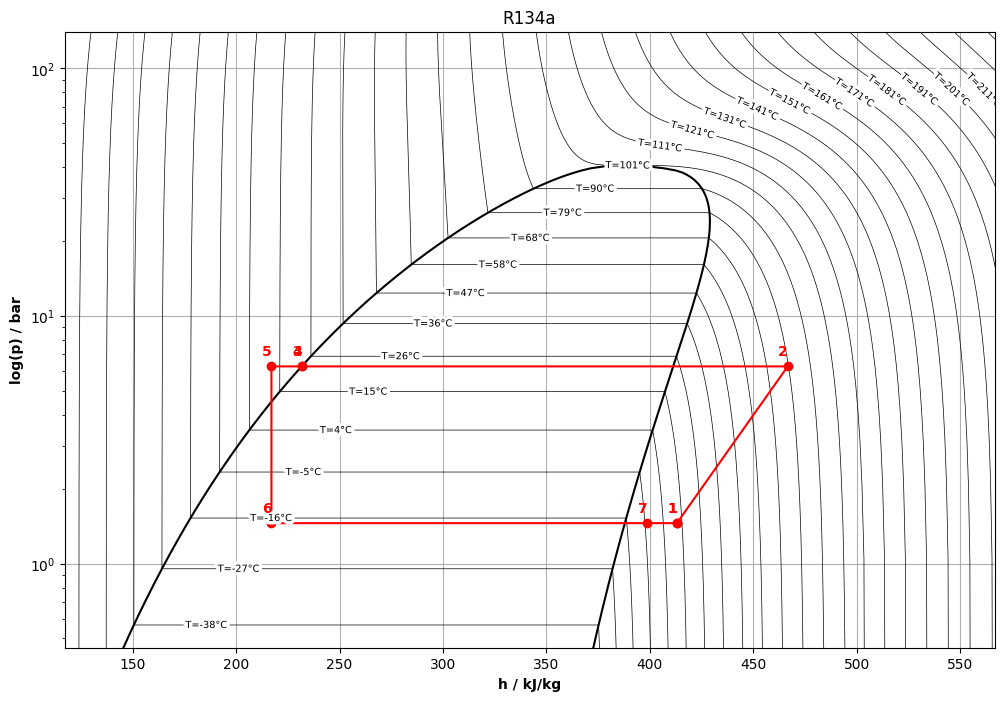

In [21]:
# Plot the refrigeration cycle in a log(p)–h diagram

logph(
    [[h1 * 1e-3, h2 * 1e-3, h3 * 1e-3, h4 * 1e-3, h5 * 1e-3, h6 * 1e-3, h7 * 1e-3, h1 * 1e-3]],
    [[p1 * 1e-5, p2 * 1e-5, p3 * 1e-5, p4 * 1e-5, p5 * 1e-5, p6 * 1e-5, p7 * 1e-5, p1 * 1e-5]],
    [[1, 2, 3, 4, 5, 6, 7, 1]],
    [net.fluid_loops[1]]
)


### 3.9 Reporting of Key Results

For convenience, the main steady-state performance indicators of the
refrigeration cycle are summarized below.


In [22]:

# Print selected steady-state performance indicators of the system
print(
    f"Refrigerant mass flow rate: {m_r:.3f} kg/s\n"
    f"Evaporator heat transfer rate: {Q_evap * 1e-3:.3f} kW\n"
    f"Condenser heat transfer rate: {Q_cond * 1e-3:.3f} kW\n"
    f"Compressor power consumption: {P_comp * 1e-3:.3f} kW \n"
    f"Evaporator superheat: {dTsh:.3f} K"
)

Refrigerant mass flow rate: 0.085 kg/s
Evaporator heat transfer rate: 15.452 kW
Condenser heat transfer rate: 20.017 kW
Compressor power consumption: 4.566 kW 
Evaporator superheat: 12.805 K


The results confirm that the network formulation yields a physically consistent
steady-state solution of the vapor compression refrigeration cycle for the
prescribed system inputs.


## 4. Inverse Problem <a id="inverse-problem-formulation"></a>

We now consider the **inverse problem** associated with the vapor compression
refrigeration cycle introduced above.

In contrast to classical approaches, in which inverse problems are typically
solved by repeatedly evaluating the forward (direct) problem for different
candidate inputs, the proposed methodology formulates the inverse problem as a
**simultaneous problem**, using simultaneous analysis and design
(SAND) formulation [4].

Within the present framework, the tearing variables $\mathbf{z}$ and a selected
subset of system inputs $\mathbf{u}^{var}$ are treated as unknowns
simultaneously, while the remaining inputs $\mathbf{u}^{fix}$ remain prescribed.

The inverse problem is solved by enforcing all steady-state balance equations
and constraints of the thermal–hydraulic network, while minimizing the mismatch
between simulated system outputs and prescribed target quantities
$\mathbf{y}^{*}$.

Formally, the inverse problem is posed as a constrained optimization problem of
the form

$$
\begin{aligned}
& \underset{\mathbf{u}^{\mathrm{var}},\,\mathbf{z}}{\arg\min}
\quad
\mathcal{J}
=
\left\|
\mathbf{y}^{*}
-
\mathbf{S}\,
\mathbf{y}\!\left(
\mathbf{z}, \mathbf{u}^{\mathrm{var}} \mid \mathbf{u}^{\mathrm{fix}}
\right)
\right\|_2 \\
& \text{subject to} \quad
r\!\left(
\mathbf{z}, \mathbf{u}^{\mathrm{var}} \mid \mathbf{u}^{\mathrm{fix}}
\right)
= \mathbf{0}, \\
& \quad\quad\quad\;
c\!\left(
\mathbf{z}, \mathbf{u}^{\mathrm{var}} \mid \mathbf{u}^{\mathrm{fix}}
\right)
= \mathbf{0}, \\
& \quad\quad\quad\;
g\!\left(
\mathbf{z}, \mathbf{u}^{\mathrm{var}} \mid \mathbf{u}^{\mathrm{fix}}
\right)
\le \mathbf{0}, \\
& \quad\quad\quad\;
\underline{\mathbf{x}}
\le
\mathbf{x}\!\left(
\mathbf{z}, \mathbf{u}^{\mathrm{var}} \mid \mathbf{u}^{\mathrm{fix}}
\right)
\le
\overline{\mathbf{x}}, \\
& \quad\quad\quad\;
\underline{\mathbf{u}}^{\mathrm{var}}
\le
\mathbf{u}^{\mathrm{var}
}
\le
\overline{\mathbf{u}}^{\mathrm{var}} .
\end{aligned}
$$

Here, $r(\cdot)$ denotes the residual equations arising from the network
formulation, $c(\cdot)$ represents additional equality constraint equations,
and $g(\cdot)$ denotes inequality constraints.

The matrix $\mathbf{S}$ acts as a **selection operator** that maps the full
output vector $\mathbf{y}$ to the subset of outputs for which target values
$\mathbf{y}^*$ are specified. This allows inverse problems to be formulated
flexibly without modifying the underlying network model or output definitions.

Bound constraints on internal system variables $\mathbf{x}$ restrict the solution to
physically admissible operating regions, while bounds on the variable inputs
$\mathbf{u}^{var}$ define admissible ranges for control variables such as
compressor speed or expansion valve opening.

In this formulation, the steady-state balance equations are not solved
separately in an inner loop. Instead, they are enforced directly as constraints
of the optimization problem.

As a result, the inverse problem is solved in a single, unified system that
simultaneously determines the tearing variables and the unknown system inputs.



### 4.1 Selection of Variable Inputs

To formulate the inverse problem for the present test case, a subset of system
inputs is selected as optimization variables $\mathbf{u}^{var}$, while the
remaining inputs $\mathbf{u}^{fix}$ remain prescribed.

The choice of variable inputs reflects typical actuation mechanisms available
in vapor compression refrigeration systems.

In this example, the following quantities are treated as variable inputs:

- compressor rotational speed $\omega$,
- expansion valve opening area $A_v$.

Accordingly, the vector of variable inputs is given by

$$
\mathbf{u}^{var}
=
\begin{bmatrix}
\omega &
A_v
\end{bmatrix}^{\top}.
$$

All remaining system inputs are kept fixed and form the vector
$\mathbf{u}^{fix}$. For the present test case, these include the prescribed
boundary conditions at the secondary-fluid inlet ports of the evaporator and
condenser, namely

$$
\mathbf{u}^{fix}
=
\begin{bmatrix}
p_{i,\mathrm{af,evap}} &
h_{i,\mathrm{af,evap}} &
\dot{m}_{i,\mathrm{af,evap}} &
p_{i,\mathrm{af,cond}} &
h_{i,\mathrm{af,cond}} &
\dot{m}_{i,\mathrm{af,cond}}
\end{bmatrix}^{\top}.
$$

Within the framework, this distinction is implemented explicitly by the
parameter attribute `is_var`.

Setting `is_var=True` for a parameter indicates that its value is treated as an
optimization variable and becomes part of the decision vector
$\mathbf{u}^{var}$. Parameters for which `is_var=False` remain fixed during the
optimization and belong to $\mathbf{u}^{fix}$.

This design enables a clear and transparent formulation of inverse problems:
the same network model can be used for both direct and inverse problems, and
the role of individual parameters can be changed without modifying the model
structure or component equations.

The admissible operating range of each variable input is defined through
parameter bounds, which are enforced directly by the optimizer.


In [23]:
# Selection of variable system inputs for the inverse problem
#
# The following parameters are treated as optimization variables u^{var}.
# Their values are adjusted by the optimizer within the specified bounds.

net.set_parameter(
    "Comp",
    "omega",
    value=2000,
    is_var=True,
    scale_factor=1.0e-3,
    bounds=(750, 3500),
)

net.set_parameter(
    "Exp",
    "Av",
    value=0.5,
    is_var=True,
    scale_factor=1.0,
    bounds=(0.1, 1.0),
)


### 4.2 Definition of Target Quantities

In the inverse problem, desired operating conditions are specified through
target values for selected system outputs.

Let $\mathbf{y}$ denote the vector of system outputs computed from the solution
of the network equations. Only a subset of these outputs is associated with
prescribed target values. This subset is denoted by the target vector
$\mathbf{y}^*$.

For the present test case, the following target quantities are considered:

- evaporator refrigerant superheat $\Delta T_{sh}$,
- evaporator cooling load $\dot{Q}_{\mathrm{evap}}$.

Accordingly, the target vector is given by

$$
\mathbf{y}^*
=
\begin{bmatrix}
\Delta T_{sh}^* &
\dot{Q}_{\mathrm{evap}}^*
\end{bmatrix}^{\top}.
$$

These target quantities represent typical operational requirements in
refrigeration systems, combining thermodynamic control objectives with
performance-based constraints.

Each target quantity gives rise to an individual objective contribution
$\mathcal{J}_i$, defined as the absolute deviation between the simulated system
quantity and its prescribed target value.

The evaporator superheat objective is defined as

$$
\mathcal{J}_{\Delta T_{sh}}
=
\left(
h_{o,r,\mathrm{evap}}
-
h\!\left(
p_{o,r,\mathrm{evap}},
T_s\!\left(p_{o,r,\mathrm{evap}}\right) + \Delta T_{sh}^*
\right)
\right)^2,
$$

where $h_{o,r,\mathrm{evap}}$ and $p_{o,r,\mathrm{evap}}$ denote the refrigerant
outlet specific enthalpy and pressure at the evaporator, respectively, and
$T_s(p_{o,r,evap})$ denotes the saturation temperature at pressure $p_{o,r,evap}$.

The cooling-load objective is given by

$$
\mathcal{J}_{Q}
=
\left(
\dot{Q}_{\mathrm{evap}}
-
\dot{Q}_{\mathrm{evap}}^*
\right)^2.
$$

The overall objective function is constructed as a weighted sum of these
individual contributions,

$$
\mathcal{J}
=
w_{\Delta T_{sh}} \, \mathcal{J}_{\Delta T_{sh}}
+
w_{Q} \, \mathcal{J}_{Q},
$$

where the weighting factors $w_i$ are used to balance the relative importance
and numerical scaling of the different target specifications.


### 4.3 Specification of Target Values

The inverse problem is parameterized by prescribed target values for the
selected objective quantities.

These target values define the desired operating point of the refrigeration
system and correspond to the components of the target vector $\mathbf{y}^*$.

In the present test case, the targets are:

- a desired refrigerant superheat at the evaporator outlet,
- a desired evaporator cooling load.

The numerical values of these targets are defined in the following code cell
and are used by the objective constraint functions to compute the individual
objective contributions $\mathcal{J}_i$.


In [24]:
# Target values for the inverse problem
#
# These quantities define the desired operating point of the system.
# Deviations from these targets are minimized by the optimizer.

DeltaT_sh_target = 5.0        # Target evaporator superheat [K]
Q_evap_target = 1.8e4         # Target evaporator heat transfer rate [W]


### 4.4 Definition of Objective Constraint Functions

Each objective contribution $\mathcal{J}_i$ is implemented as a callable
Python function.

An objective constraint function:

- takes the initialized network object as its only input,
- accesses the current values of the relevant component ports and outputs,
- computes the deviation between a simulated quantity and its prescribed
  target value,
- returns a scalar residual.

These residuals are interpreted by the framework as objective contributions
when the constraint is registered with `ctype="obj"`.

This design allows the objective function to be assembled automatically from
multiple objective constraints, while all steady-state balance equations and
additional constraints are enforced simultaneously.


In [25]:
# Define the object constraints by callable python functions

def superheat_obj(net):
    # Mismatch in evaporator outlet superheat
    p = net.components['Evap'].ports["out_r"].p.value
    h = net.components['Evap'].ports["out_r"].h.value
    fluid = net.components['Evap'].ports["out_r"].fluid

    T_sat = PropsSI('T', 'P', p, 'Q', 1.0, fluid)
    h_sh_target = PropsSI('H', 'T', T_sat + DeltaT_sh_target, 'P', p, fluid)

    return h - h_sh_target


def cooling_load_obj(net):
    # Mismatch in evaporator cooling capacity
    Q = net.components['Evap'].outputs['Q'].value
    return Q - Q_evap_target


### 4.5 Registration and Weighting of Objective Constraints

The objective constraint functions are registered at the network level using
the method `net.add_constraint`.

By specifying `ctype="obj"`, the returned residuals are treated as components
of the global objective function rather than as equality constraints.

Each objective constraint is assigned a weighting factor using the argument
`scale_factor`. These weighting factors serve two purposes:

- they balance the relative importance of the different target quantities,
- they improve numerical conditioning by scaling the objective contributions
  to comparable magnitudes.

The resulting optimization problem is solved by simultaneously enforcing all
steady-state balance equations and minimizing the weighted objective function,
in accordance with the SAND formulation introduced in the paper.


In [26]:
# Add objective contributions
net.add_constraint(
    "superheat_objective",
    superheat_obj,
    ctype="obj",
    scale_factor=1e-5
)

net.add_constraint(
    "cooling_load_objective",
    cooling_load_obj,
    ctype="obj",
    scale_factor=1e-3
)


### 4.6 Explicit Constrained Optimization Problem for the Test Case

For the present test case, the general inverse problem formulation introduced
in Eq. (26) of the paper reduces to the following constrained nonlinear
optimization problem.

The decision variables are the compressor rotational speed $\omega$ and the
expansion valve opening area $A_v$.

The optimization problem reads

$$
\begin{aligned}
\underset{\omega,\,A_v}{\arg\min}
\quad &
\sqrt{
w_{\dot{Q}_{evap}}\mathcal{J}_{\dot{Q}_{\mathrm{evap}}}
+
w_{\Delta T_{sh}} \mathcal{J}_{\Delta T_{sh}}
}
\\
\text{subject to}
\quad &
h_{o,\mathrm{cond}} - h_s\!\left(p_{o,\mathrm{cond}}\right) = 0,
\\
&
p_{i,\mathrm{co}} - p_{o,\mathrm{ihx},c} = 0,
\\
&
h_{i,\mathrm{co}} - h_{o,\mathrm{ihx},c} = 0,
\\
&
p_{i,\mathrm{exp}} - p_{o,\mathrm{ihx},h} = 0,
\\
&
h_{i,\mathrm{exp}} - h_{o,\mathrm{ihx},h} = 0,
\\
&
\dot{m}_{i,\mathrm{exp}} - \dot{m}_{o,\mathrm{ihx},h} = 0,
\\
&
750 \leq \omega \leq 3500,
\\
&
0.1 \leq A_v \leq 1.0.
\end{aligned}
$$


Here, $\mathcal{J}_{\dot{Q}_{\mathrm{evap}}}$ and
$\mathcal{J}_{\Delta T_{sh}}$ denote the objective contributions associated
with the evaporator cooling load and the evaporator superheat, respectively.

The square-root formulation corresponds to the Euclidean norm of the vector of
objective residuals and is equivalent to the least-squares objective used in
the general formulation.

The equality constraints enforce physical consistency of the steady-state
solution. The first constraint imposes saturated liquid conditions at the
condenser outlet and replaces the mass balance equation removed by the loop
breaker. The remaining constraints correspond to the reduced set of network
residual equations obtained after application of the tearing algorithm.

The bound constraints on $\omega$ and $A_v$ define admissible operating ranges
for the actuator variables and are enforced directly by the optimizer.

Within the framework, this optimization problem is assembled automatically by:

- declaring $\omega$ and $A_v$ as variable parameters using `is_var=True`,
- registering the physical closure relation as an equality constraint
  (`ctype="eq"`),
- defining the objective contributions as objective-type constraints
  (`ctype="obj"`),
- and specifying bounds on the variable parameters.

This explicit formulation illustrates how the abstract inverse problem
definition is instantiated for a concrete thermal–hydraulic system without
introducing nested solution loops.


### 4.7 Solution of the Inverse Problem


The constrained optimization problem defined above is solved using a Sequential
Least Squares Quadratic Programming (SLSQP) algorithm.

Within the framework, the inverse problem is solved by simultaneously:

- enforcing all steady-state balance equations and equality constraints,
- satisfying bound constraints on the variable inputs,
- minimizing the global objective function composed of the selected target
  quantities.

In contrast to classical nested approaches, no repeated solution of the direct
problem is required. Instead, the tearing variables and the variable system
inputs are updated jointly within a single optimization loop.



In [ ]:
# Solve the inverse problem
#
# The optimizer simultaneously updates the tearing variables and the selected
# variable inputs (omega, Av) until all constraints are satisfied and the
# objective function is minimized.

net.solve_system_notebook()


 Start solver...
Residual norm = 2.026e+00, Obj = 2.128e+05


### 4.8 Post-Processing and Visualization of the Inverse Problem Solution

After convergence of the inverse problem, the steady-state solution of the
thermal–hydraulic network is post-processed to analyze the resulting operating
point.

First, the pressures, specific enthalpies, and mass flow rates at the
refrigerant ports are extracted in order to reconstruct the thermodynamic
cycle.

Based on these states, the refrigeration cycle is visualized in a
logarithmic pressure–enthalpy diagram.

In addition, key steady-state performance indicators are evaluated, including:

- refrigerant mass flow rate,
- evaporator and condenser heat transfer rates,
- compressor power consumption,
- evaporator superheat,

Finally, the optimal values of the variable system inputs obtained from the
inverse problem are reported.


In [ ]:
# Extract steady-state results of the inverse problem
res_invp = net.get_results()

# Refrigerant-side states along the cycle
p1 = res_invp["ports"]["Comp"]["in"]["p"]
p2 = res_invp["ports"]["Comp"]["out"]["p"]
h1 = res_invp["ports"]["Comp"]["in"]["h"]
h2 = res_invp["ports"]["Comp"]["out"]["h"]

p3 = res_invp["ports"]["Cond"]["out_r"]["p"]
h3 = res_invp["ports"]["Cond"]["out_r"]["h"]

p4 = res_invp["ports"]["Rev"]["out"]["p"]
h4 = res_invp["ports"]["Rev"]["out"]["h"]

p5 = res_invp["ports"]["IHX"]["out_hot"]["p"]
h5 = res_invp["ports"]["IHX"]["out_hot"]["h"]

p6 = res_invp["ports"]["Exp"]["out"]["p"]
h6 = res_invp["ports"]["Exp"]["out"]["h"]

p7 = res_invp["ports"]["Evap"]["out_r"]["p"]
h7 = res_invp["ports"]["Evap"]["out_r"]["h"]

m_r = res_invp["ports"]["Comp"]["in"]["m"] # refrigerant mass flow rate

Q_evap = res_invp["outputs"]["Evap"]["Q"]  # evaporator heat transfer rate 

Q_cond = res_invp["outputs"]["Cond"]["Q"]  # condenser heat transfer rate

P_comp = res_invp["outputs"]["Comp"]["P"]  # compressor power

dTsh = res_invp["outputs"]["Evap"]["dTsh"] # evaporator superheat

# Plot the refrigeration cycle in a log(p)–h diagram
logph(
    [[h1*1e-3, h2*1e-3, h3*1e-3, h4*1e-3, h5*1e-3, h6*1e-3, h7*1e-3, h1*1e-3]],
    [[p1*1e-5, p2*1e-5, p3*1e-5, p4*1e-5, p5*1e-5, p6*1e-5, p7*1e-5, p1*1e-5]],
    [[1, 2, 3, 4, 5, 6, 7, 1]],
    [net.fluid_loops[1]],
)

# Print selected steady-state performance indicators
print(
    f"Refrigerant mass flow rate: {m_r:.3f} kg/s\n"
    f"Evaporator heat transfer rate: {Q_evap*1e-3:.3f} kW\n"
    f"Condenser heat transfer rate: {Q_cond*1e-3:.3f} kW\n"
    f"Compressor power consumption: {P_comp*1e-3:.3f} kW\n"
    f"Evaporator superheat: {dTsh:.3f} K\n"
)

# Extract optimal variable inputs
omega_opt = net.components["Comp"].parameter["omega"].value
Av_opt = net.components["Exp"].parameter["Av"].value

print(f"Optimal compressor speed: {omega_opt:.1f} rpm")
print(f"Optimal expansion valve opening: {Av_opt:.3f}")


### 4.9 Interpretation of the Inverse Problem Results

The reconstructed log(p)–h diagram confirms that the optimized operating point
corresponds to a physically consistent vapor compression cycle.

The evaporator superheat and cooling load closely match their prescribed target
values, indicating successful convergence of the inverse problem.

The resulting compressor speed and expansion valve opening represent feasible
and physically meaningful actuator settings for the given boundary conditions.

This result illustrates the key advantage of the proposed methodology: the
inverse problem is solved in a single optimization problem in which the tearing
variables and selected system inputs are determined simultaneously, without
requiring repeated solution of the direct problem.


## 5. Summary <a id="summary"></a>

This notebook demonstrated the application of the proposed steady-state
thermal–hydraulic modeling framework to both direct and inverse problem
formulations using a single-stage vapor compression refrigeration cycle as a
test case.

First, the thermo-hydraulic network was constructed from modular component
models with explicitly defined computational causality. System-level coupling
and physical consistency were enforced implicitly through junction balance
equations. An established tearing strategy was applied to reduce the nonlinear
equation system to a small set of tearing variables.

For the direct problem, all system inputs were prescribed and the reduced
nonlinear system was solved to obtain the steady-state operating point and
associated performance quantities.

For the inverse problem, selected system inputs were declared as optimization
variables using the `is_var` mechanism. Desired operating conditions were
formulated as objective-type constraints, while all steady-state balance
equations and physical closure relations were enforced simultaneously. This
resulted in a single constrained optimization problem consistent with the
simultaneous analysis and design (SAND) formulation presented in the paper.

The results illustrate that the framework enables a unified and transparent
treatment of direct and inverse steady-state thermal–hydraulic problems without
requiring nested solution strategies. Implemented in Python, the framework
supports reproducible modeling workflows and provides a flexible foundation
for set-point-driven analysis, design, and optimization of coupled
thermal–hydraulic energy systems.


## References

[1] I. H. Bell, J. Wronski, S. Quoilin, and V. Lemort (2014). *Pure and pseudo-pure
fluid thermophysical property evaluation and the open-source thermophysical
property library CoolProp*. Industrial & Engineering Chemistry Research,
53(6), 2498–2508. https://doi.org/10.1021/ie4033999

[2] M. R. Osborne (1969), On shooting methods for boundary value problems, Journal of mathematical analysis and applications 27 (2) 417-433.

[3] P. von Böckh, T. Wetzel (2014), Wärmeübertragung, 5th Edition, Springer 
 
[4] J. R. R. A. Martins, A. Ning (2022), Engieering Design Optimization, Cambridge University Press, Cambridge, UK. https://doi.org/10.1017/9781108980647
